# Subsetting with `extract_model`

In [1]:
# Setup custom styling for this jupyter notebook
from IPython.core.display import HTML
from pathlib import Path

def css_styling():
    buf = Path('./css/custom.css').read_text()
    style_header = f'<style>\n{buf}\n</style>\n'
    return HTML(style_header)
css_styling()

In [2]:
from matplotlib import pyplot as plt

def figure(*args, figsize=(18, 8), facecolor='white', **kwargs):
    """Return a new figure."""
    return plt.subplots(*args, figsize=figsize, facecolor=facecolor, **kwargs)

In [3]:
from matplotlib import tri
from matplotlib import patches
import xarray as xr
import netCDF4 as nc4
import numpy as np
import extract_model as em
from extract_model.grids.triangular_mesh import UnstructuredGridSubset

In [4]:
# A helper function to make plotting variables from unstructured data easier.
def plot_unstructured_variable(ds, varname, xvarname='x', yvarname='y', vmin=None, vmax=None, buf=None, bbox=None, **kwargs):
    """Plot a variable from an unstructured grid."""
    x = ds[xvarname][:].to_numpy()
    y = ds[yvarname][:].to_numpy()
    nv = ds['nv'][:].to_numpy().T - 1
    triang = tri.Triangulation(x, y, nv)
    
    x_vertices = x[nv]
    xmin = np.min(x_vertices.flatten())
    xmax = np.max(x_vertices.flatten())
    
    y_vertices = y[nv]
    ymin = np.min(y_vertices.flatten())
    ymax = np.max(y_vertices.flatten())
    
    C = ds.isel(time=0, siglay=-1, siglev=-1)[varname][:]
    
    fig, ax = figure(**kwargs)
    cbar = ax.tripcolor(triang, C)
    fig.colorbar(cbar)
    if buf is None:
        buf = 0
    ax.set_xlim([xmin-buf, xmax+buf])
    ax.set_ylim([ymin-buf, ymax+buf])
    ax.triplot(triang, color='gray', linewidth=0.2)
    ax.grid(linewidth=0.5)
    ax.set_title(ds[varname].long_name)
    ax.set_xlabel(ds[xvarname].long_name)
    ax.set_ylabel(ds[yvarname].long_name)
    if bbox is not None:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    return fig, ax

### Lake Erie Operational Forecast System (LEOFS) FVCOM

Initialize the dataset object, but use our engine so that we can load FVCOM data into an xarray Dataset.

In [5]:
url = 'https://www.ncei.noaa.gov/thredds/dodsC/model-leofs/2022/07/nos.leofs.fields.n006.20220720.t00z.nc'

In [6]:
# We use a custom engine to support loading unstructured grids into xarray. The
# current version of xarray doesn't support coordinate variables having multiple
# dimensions, and technically it's not allowed according to the NUG and I think
# it's forbidden by CF as well. The custom version engine titled
# triangularmesh_netcdf allows clients to rename variables after the data
# arrays are constructed but before the xarray Dataset is assembled. This
# allows us to load the unstructured model output and rename the z coordinate
# variables siglay and siglev to sigma_layers and sigma_levels respectively.

# We also drop the Itime and Itime2 variables which are redundant to the time
# coordinate variable. These variables also interfere with cf-xarray and
# decoding times.

# MOST importantly, we specify the chunk size to be 1,N along the time
# coordinate. Without specifying a good chunk size, operations will take
# prohibitively long, and by default xarray makes extremely poor choices for
# chunksizes on unstructured grids, or at the very least with FVCOM.

ds = xr.open_dataset(url,
                     engine='triangularmesh_netcdf',
                     decode_times=True,
                     preload_varmap={'siglay': 'sigma_layers', 'siglev': 'sigma_levels'},
                     drop_variables=['Itime', 'Itime2'],
                     chunks={'time':1})

(<Figure size 1728x576 with 2 Axes>,
 <AxesSubplot:title={'center':'temperature'}, xlabel='nodal longitude', ylabel='nodal latitude'>)

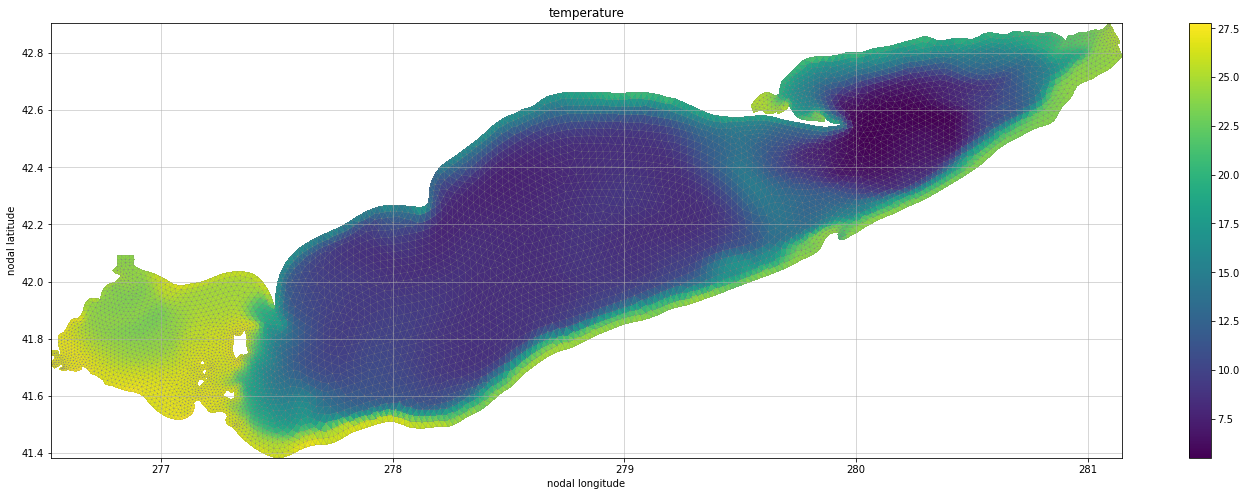

In [7]:
plot_unstructured_variable(ds, 'temp', xvarname='lon', yvarname='lat', figsize=(24,8))

Now consider that we desire to view only the southwestern portion of Lake Erie.

(<Figure size 1728x576 with 2 Axes>,
 <AxesSubplot:title={'center':'temperature'}, xlabel='nodal longitude', ylabel='nodal latitude'>)

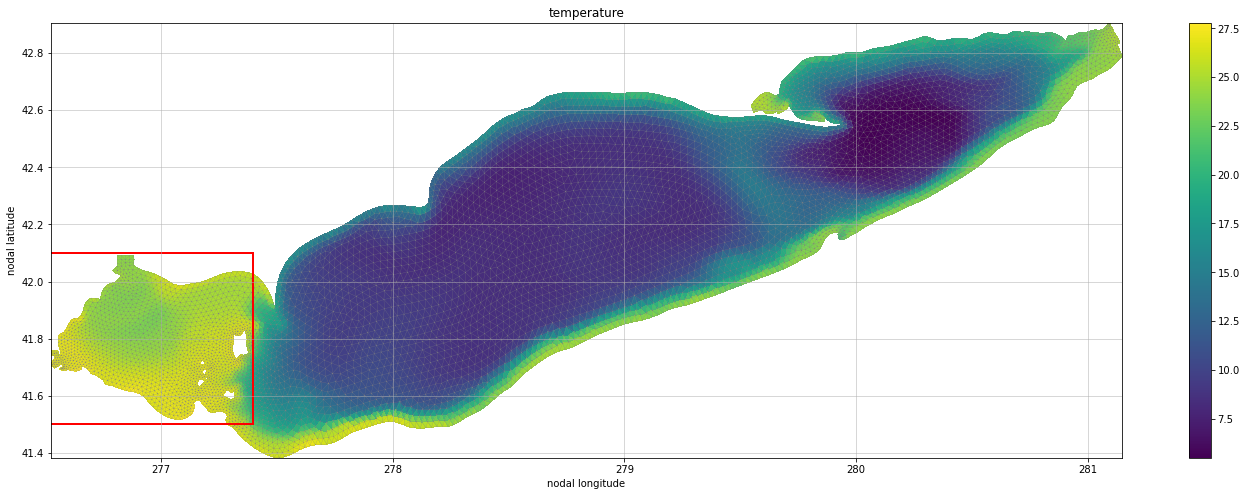

In [8]:
bbox = (276.4, 41.5, 277.4, 42.1)
plot_unstructured_variable(ds, 'temp', xvarname='lon', yvarname='lat', bbox=bbox, figsize=(24,8))

Subsetting the dataset is simple with the `ds.em.sub_bbox` method.

In [9]:
%%time
ds_ss = ds.em.sub_bbox(bbox=bbox)

CPU times: user 1.13 s, sys: 68.3 ms, total: 1.2 s
Wall time: 2.16 s


Plotting the new dataset we can see that only the relevant cells from the model output are available, any cells wholly external to the region of interest are discarded from the subsetted dataset.

(<Figure size 1728x576 with 2 Axes>,
 <AxesSubplot:title={'center':'temperature'}, xlabel='nodal longitude', ylabel='nodal latitude'>)

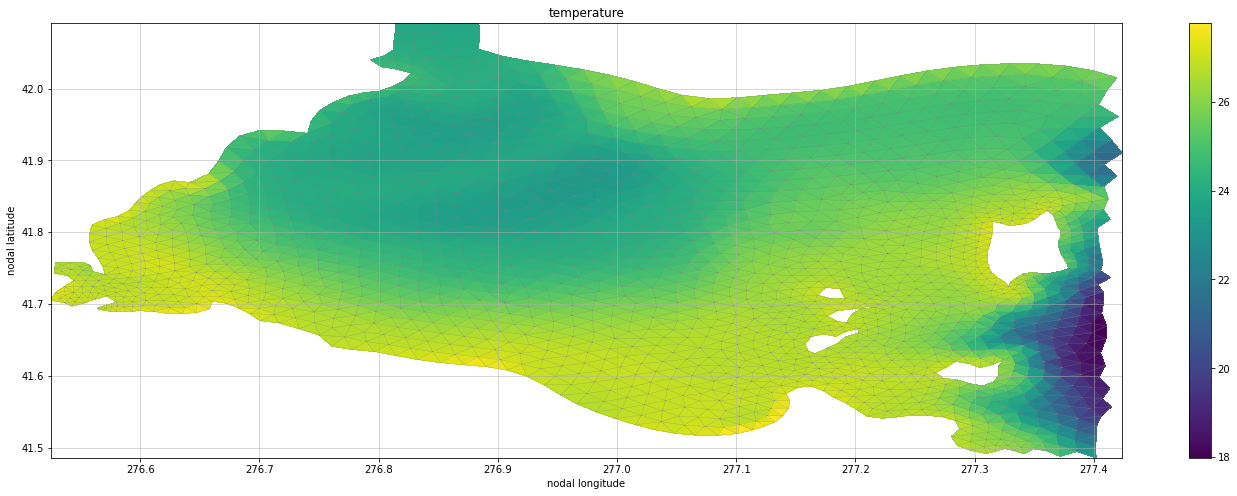

In [10]:
plot_unstructured_variable(ds_ss, 'temp', xvarname='lon', yvarname='lat', figsize=(24,8))

Now that we have subsetted the data to a region of interest we can write that data to disk.
<div class="note">
        The data saved to disk will not match the model output exactly. The <code>siglay</code> and <code>siglev</code>
        variables have been renamed to <code>sigma_layers</code> and
        <code>sigma_levels</code> respectively. The variables <code>Itime</code> and <code>Itime2</code> have been
        discarded.

</div>



In [11]:
%%time
ds_ss.to_netcdf('/tmp/fvcom-subset.nc')

CPU times: user 1.76 s, sys: 112 ms, total: 1.87 s
Wall time: 9.6 s


### Northern Golf of Mexico Operational Forecast System (NGOFS2) FVCOM

In [12]:
url = 'https://www.ncei.noaa.gov/thredds/dodsC/model-ngofs2-files/2022/07/nos.ngofs2.fields.n006.20220725.t03z.nc'

In [13]:
ds = xr.open_dataset(url, engine='triangularmesh_netcdf', decode_times=True, preload_varmap={'siglay': 'sigma_layers', 'siglev': 'sigma_levels'}, drop_variables=['Itime', 'Itime2'], chunks={'time':1})

(<Figure size 1728x576 with 2 Axes>,
 <AxesSubplot:title={'center':'temperature'}, xlabel='nodal longitude', ylabel='nodal latitude'>)

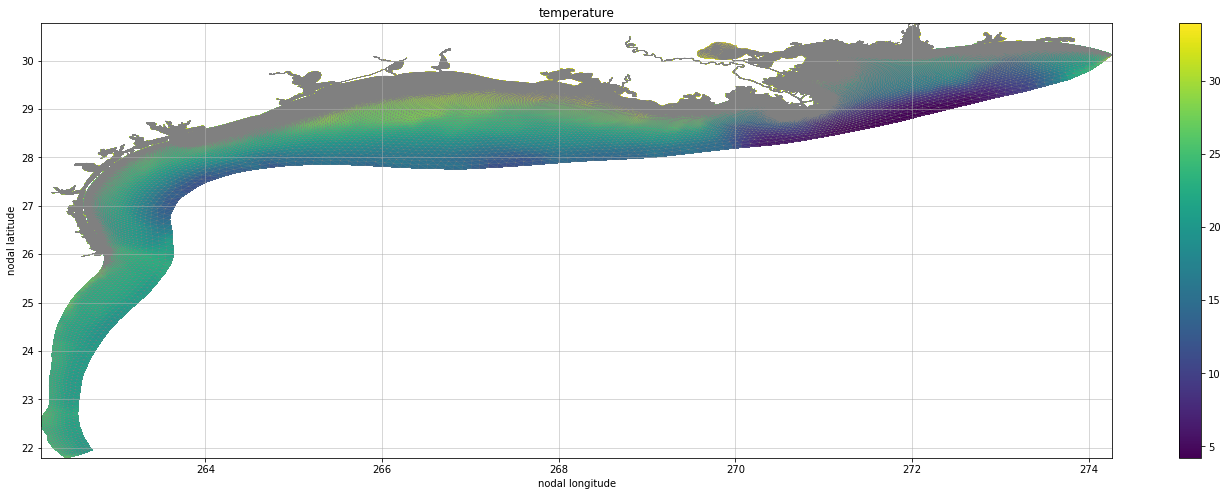

In [14]:
plot_unstructured_variable(ds, 'temp', xvarname='lon', yvarname='lat', figsize=(24,8))

Consider that we want to subset onto a region around southern Louisiana.

(<Figure size 1728x576 with 2 Axes>,
 <AxesSubplot:title={'center':'temperature'}, xlabel='nodal longitude', ylabel='nodal latitude'>)

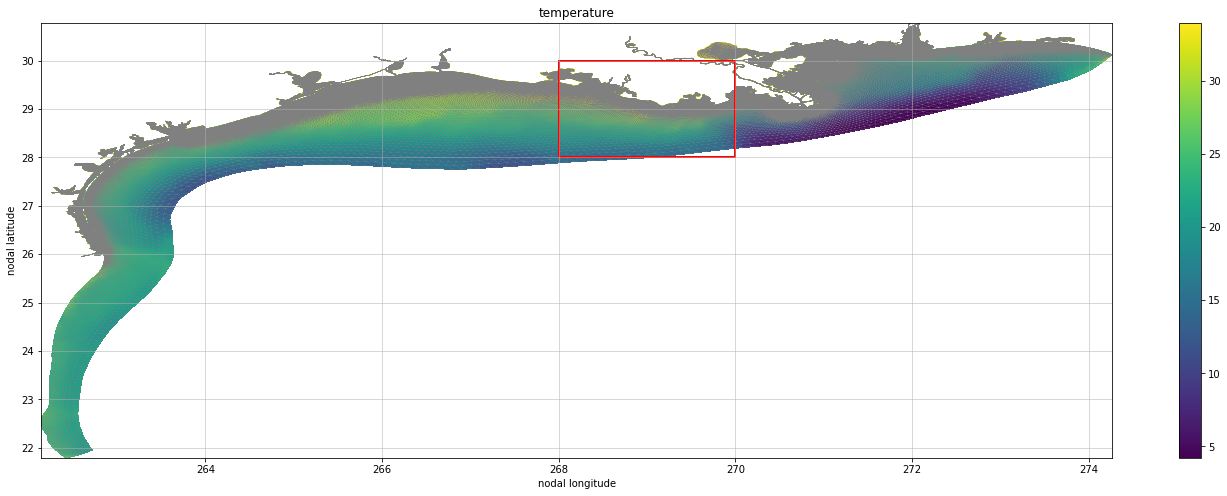

In [15]:
bbox = (268, 28, 270, 30)

plot_unstructured_variable(ds, 'temp', xvarname='lon', yvarname='lat', bbox=bbox, figsize=(24,8))

In [16]:
%%time
ds_ss = ds.em.sub_bbox(bbox=bbox, model_type='FVCOM')

CPU times: user 1.24 s, sys: 142 ms, total: 1.38 s
Wall time: 3.48 s


(<Figure size 1728x576 with 2 Axes>,
 <AxesSubplot:title={'center':'temperature'}, xlabel='nodal longitude', ylabel='nodal latitude'>)

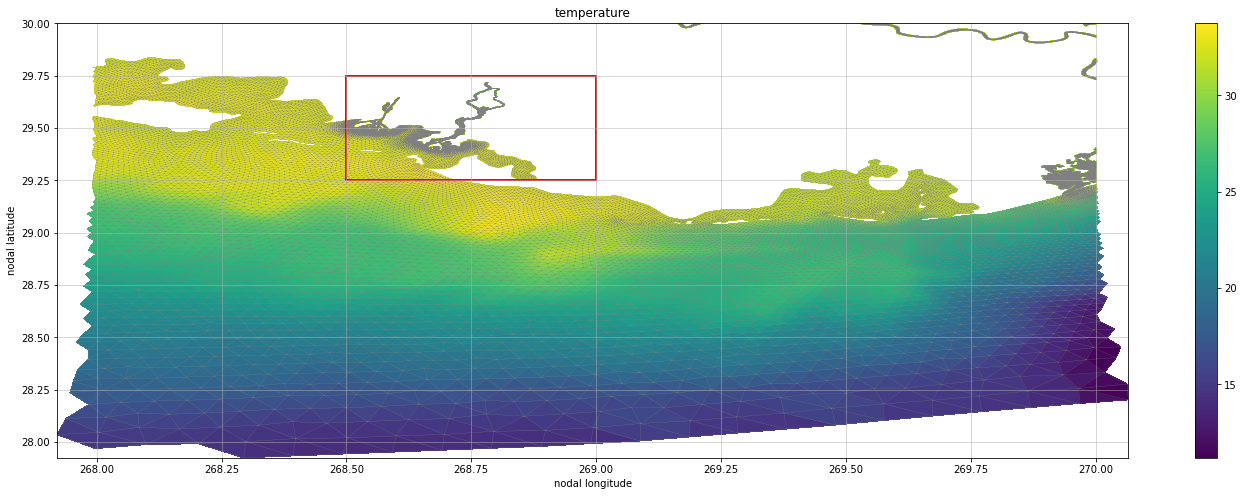

In [17]:
bbox = (268.5, 29.25, 269, 29.75)
plot_unstructured_variable(ds_ss, 'temp', xvarname='lon', yvarname='lat', bbox=bbox, figsize=(24,8))

In [18]:
ds_ss = ds_ss.em.sub_bbox(bbox=bbox)

(<Figure size 1728x576 with 2 Axes>,
 <AxesSubplot:title={'center':'temperature'}, xlabel='nodal longitude', ylabel='nodal latitude'>)

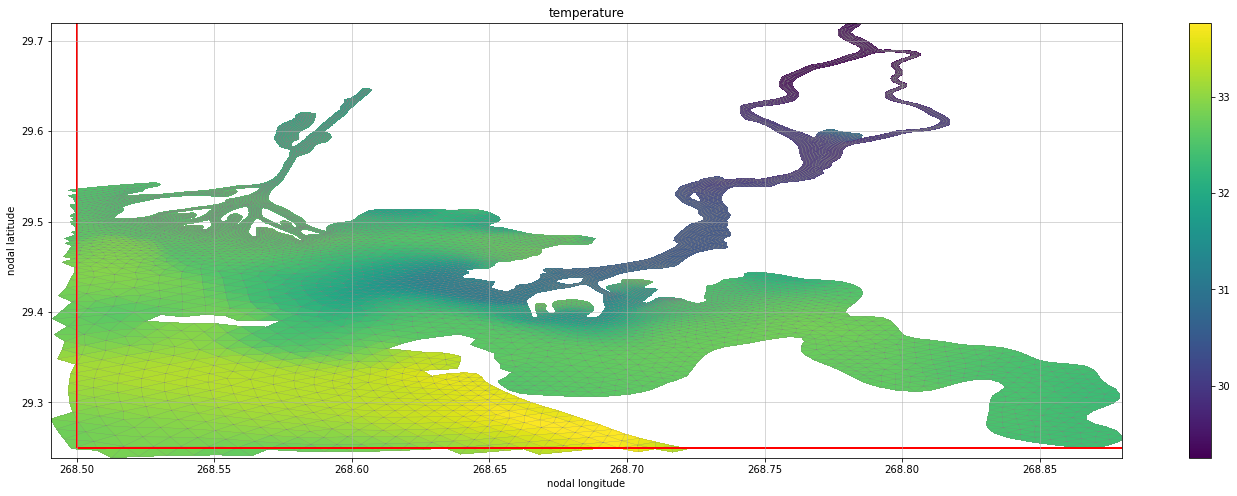

In [19]:
plot_unstructured_variable(ds_ss, 'temp', xvarname='lon', yvarname='lat', bbox=bbox, figsize=(24,8))